In [30]:
# Importing Necesasary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import joblib
from tqdm import tqdm
import time

import shap
import warnings
warnings.filterwarnings('ignore')

D:\File\Conda\envs\data-science\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Reading the Dataset
df = pd.read_csv("G:\My Drive\ITS\Tugas\Semester_5\Biomedical Engineering\Final Project Req\Dataset.csv")

In [4]:
# Handling Missing Values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
# Label Targeting and Feature Selection
label = df.columns[-1]
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_cols = [c for c in numeric_cols if c != label]

# Preparing Feature Matrix and Target Vector
X = df[feature_cols].values
y_raw = df[label].values

# Label Encoding the Target Variable
le = LabelEncoder()
y = le.fit_transform(df[label])

In [7]:
# Splitting the Dataset into Training and Val-Test Sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

# Further Splitting Val-Test Set into Validation and Test Sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                y_val_test,
                                                test_size=0.5,
                                                stratify=y_val_test,
                                                random_state=42)

In [28]:
# Checking class distribution of each set
from collections import Counter

print("Training set class distribution:", Counter(y_train))
print("\nValidation set class distribution:", Counter(y_val))
print("\nTest set class distribution:", Counter(y_test))

Training set class distribution: Counter({np.int64(2): 304, np.int64(3): 136, np.int64(0): 99, np.int64(4): 83, np.int64(1): 47})

Validation set class distribution: Counter({np.int64(2): 65, np.int64(3): 29, np.int64(0): 21, np.int64(4): 18, np.int64(1): 10})

Test set class distribution: Counter({np.int64(2): 65, np.int64(3): 29, np.int64(0): 22, np.int64(4): 18, np.int64(1): 10})


In [32]:
# Feature Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [8]:
print("Training set shape:")
print("Shape of X_Train:", X_train.shape)
print("Shape of y_Train:", y_train.shape)

print("\nValidation set shape:")
print("Shape of X_Val:", X_val.shape)
print("Shape of y_Val:", y_val.shape)

print("\nTest set shape:")
print("Shape of X_Test:", X_test.shape)
print("Shape of y_Test:", y_test.shape)


Training set shape:
Shape of X_Train: (669, 20530)
Shape of y_Train: (669,)

Validation set shape:
Shape of X_Val: (143, 20530)
Shape of y_Val: (143,)

Test set shape:
Shape of X_Test: (144, 20530)
Shape of y_Test: (144,)


In [10]:
# Enable verbose output for LogisticRegression
lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.1,
    max_iter=5000,
    n_jobs=-1,
    verbose=1
)

# Wrap the fit method with tqdm for progress bar
print("Training Lasso Logistic Regression...")
start_time = time.time()
lasso.fit(X_train_scaled, y_train)
elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time / 60:.2f} minutes.")

lasso_coef = np.mean(np.abs(lasso.coef_), axis=0)
lasso_rank_idx = np.argsort(lasso_coef)[::-1]
lasso_genes = []
for i in tqdm(lasso_rank_idx, desc="Ranking features"):
    lasso_genes.append(feature_cols[i])


Training Lasso Logistic Regression...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
D:\File\Conda\envs\data-science\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 1828 seconds
Training completed in 1827.82 seconds


Ranking features: 100%|██████████| 20530/20530 [00:00<00:00, 2361805.35it/s]


In [13]:
# Save the model to the specified path
joblib.dump(lasso, 'Saved Model/lasso_logistic_model.pkl')

['Saved Model/lasso_logistic_model.pkl']

In [16]:
y_train_pred = lasso.predict(X_train)
y_val_pred = lasso.predict(X_val)

print("\nTraining Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


Training Accuracy: 1.0
Validation Accuracy: 0.8881118881118881

Classification Report (Validation):
              precision    recall  f1-score   support

       Basal       1.00      0.95      0.98        21
        Her2       1.00      0.70      0.82        10
        LumA       0.87      0.92      0.90        65
        LumB       0.79      0.76      0.77        29
      Normal       0.95      1.00      0.97        18

    accuracy                           0.89       143
   macro avg       0.92      0.87      0.89       143
weighted avg       0.89      0.89      0.89       143



In [19]:
# Get feature coefficients and their importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lasso.coef_[0],
    'abs_coefficient': np.abs(lasso.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

Top 10 Most Important Features:
       feature  coefficient  abs_coefficient
9538     FABP7     0.049893         0.049893
16648   ABCC11    -0.046319         0.046319
8801   HORMAD1     0.045857         0.045857
17107  CEACAM5    -0.045192         0.045192
18032  CXorf61     0.043413         0.043413
10784     MSLN     0.038449         0.038449
12823    ROPN1     0.034920         0.034920
195       ART3     0.030813         0.030813
18492    VGLL1     0.030169         0.030169
8074       CA9     0.029272         0.029272


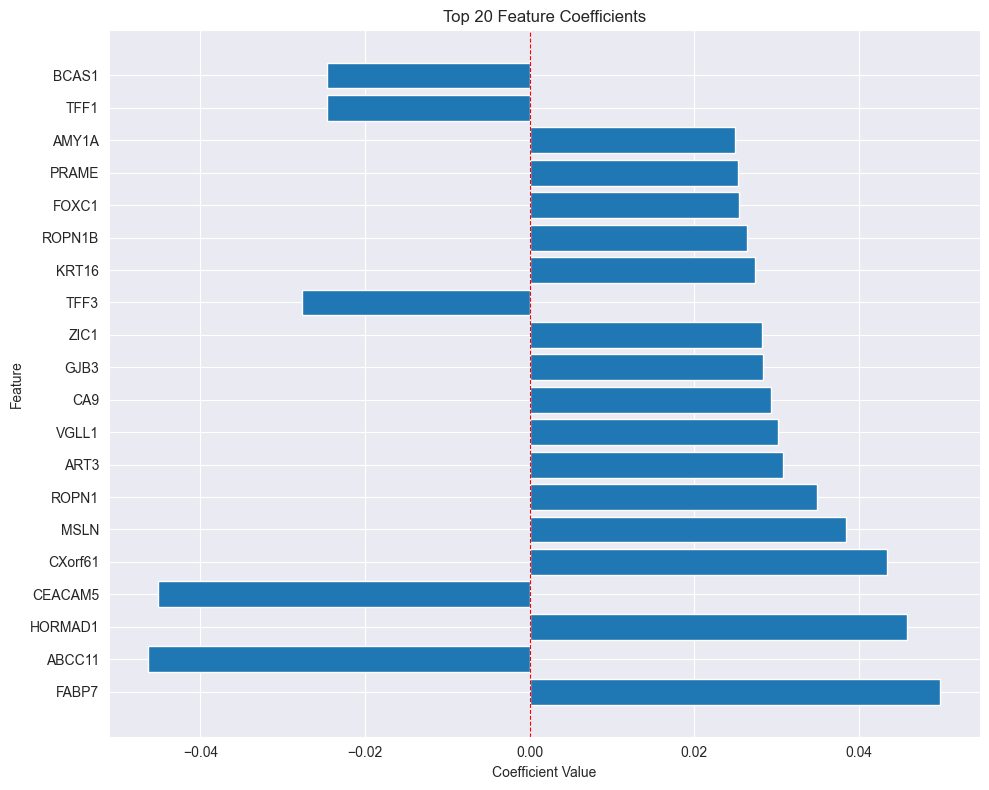

In [21]:
# Plot top 20 feature coefficients
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Coefficients')
plt.axvline(x=0, color='red', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

In [22]:
# Calculate odds ratios for better interpretation
odds_ratios = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lasso.coef_[0],
    'odds_ratio': np.exp(lasso.coef_[0])
}).sort_values('odds_ratio', ascending=False)

print("\nOdds Ratios (exp(coefficient)):")
print(odds_ratios.head(10))
print("\nInterpretation: OR > 1 increases probability, OR < 1 decreases probability")


Odds Ratios (exp(coefficient)):
       feature  coefficient  odds_ratio
9538     FABP7     0.049893    1.051158
8801   HORMAD1     0.045857    1.046925
18032  CXorf61     0.043413    1.044369
10784     MSLN     0.038449    1.039198
12823    ROPN1     0.034920    1.035537
195       ART3     0.030813    1.031293
18492    VGLL1     0.030169    1.030629
8074       CA9     0.029272    1.029705
11871     GJB3     0.028320    1.028725
5629      ZIC1     0.028192    1.028593

Interpretation: OR > 1 increases probability, OR < 1 decreases probability


In [23]:
# Show how the model makes decisions
def explain_prediction(sample_idx):
    sample = X_val[sample_idx].reshape(1, -1)
    prediction = lasso.predict(sample)[0]
    proba = lasso.predict_proba(sample)[0]

    # Calculate contribution of each feature
    contributions = sample[0] * lasso.coef_[0]
    contrib_df = pd.DataFrame({
        'feature': feature_cols,
        'value': sample[0],
        'coefficient': lasso.coef_[0],
        'contribution': contributions
    }).sort_values('contribution', key=abs, ascending=False)

    print(f"Prediction: {le.inverse_transform([prediction])[0]}")
    print(f"Probability: {proba}")
    print("\nTop 10 Contributing Features:")
    print(contrib_df.head(10))

explain_prediction(0)  # Explain first validation sample

Prediction: Normal
Probability: [0.0845466  0.04040477 0.37027679 0.01917081 0.48560104]

Top 10 Contributing Features:
       feature    value  coefficient  contribution
9538     FABP7   7.1168     0.049893      0.355078
16648   ABCC11   7.3286    -0.046319     -0.339455
17107  CEACAM5   6.5504    -0.045192     -0.296026
19117    PRAME  11.1812     0.025318      0.283087
16590     TFF3   9.4802    -0.027702     -0.262620
13725  SCGB2A2  12.6028    -0.017919     -0.225830
1212    C4orf7   9.2477     0.023922      0.221221
4713     FOXC1   8.2412     0.025484      0.210020
9867     BCAS1   8.1146    -0.024614     -0.199729
18492    VGLL1   6.2445     0.030169      0.188392


In [24]:
# Analyze top contributing features for each class
n_top_features = 10

for class_idx, class_name in enumerate(le.classes_):
    print(f"\n{'='*60}")
    print(f"Class: {class_name}")
    print('='*60)

    # Get coefficients for this class
    class_coef = lasso.coef_[class_idx]

    # Create DataFrame with features and their coefficients
    class_features = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': class_coef,
        'abs_coefficient': np.abs(class_coef)
    }).sort_values('abs_coefficient', ascending=False)

    print(f"\nTop {n_top_features} Contributing Features:")
    print(class_features.head(n_top_features).to_string(index=False))

    # Show positive and negative contributors separately
    positive_features = class_features[class_features['coefficient'] > 0].head(5)
    negative_features = class_features[class_features['coefficient'] < 0].head(5)

    print(f"\nTop 5 Positive Contributors (increase probability):")
    print(positive_features[['feature', 'coefficient']].to_string(index=False))

    print(f"\nTop 5 Negative Contributors (decrease probability):")
    print(negative_features[['feature', 'coefficient']].to_string(index=False))


Class: Basal

Top 10 Contributing Features:
feature  coefficient  abs_coefficient
  FABP7     0.049893         0.049893
 ABCC11    -0.046319         0.046319
HORMAD1     0.045857         0.045857
CEACAM5    -0.045192         0.045192
CXorf61     0.043413         0.043413
   MSLN     0.038449         0.038449
  ROPN1     0.034920         0.034920
   ART3     0.030813         0.030813
  VGLL1     0.030169         0.030169
    CA9     0.029272         0.029272

Top 5 Positive Contributors (increase probability):
feature  coefficient
  FABP7     0.049893
HORMAD1     0.045857
CXorf61     0.043413
   MSLN     0.038449
  ROPN1     0.034920

Top 5 Negative Contributors (decrease probability):
feature  coefficient
 ABCC11    -0.046319
CEACAM5    -0.045192
   TFF3    -0.027702
   TFF1    -0.024632
  BCAS1    -0.024614

Class: Her2

Top 10 Contributing Features:
 feature  coefficient  abs_coefficient
    CPB1    -0.077318         0.077318
    PNMT     0.064642         0.064642
   NXPH1     0.060

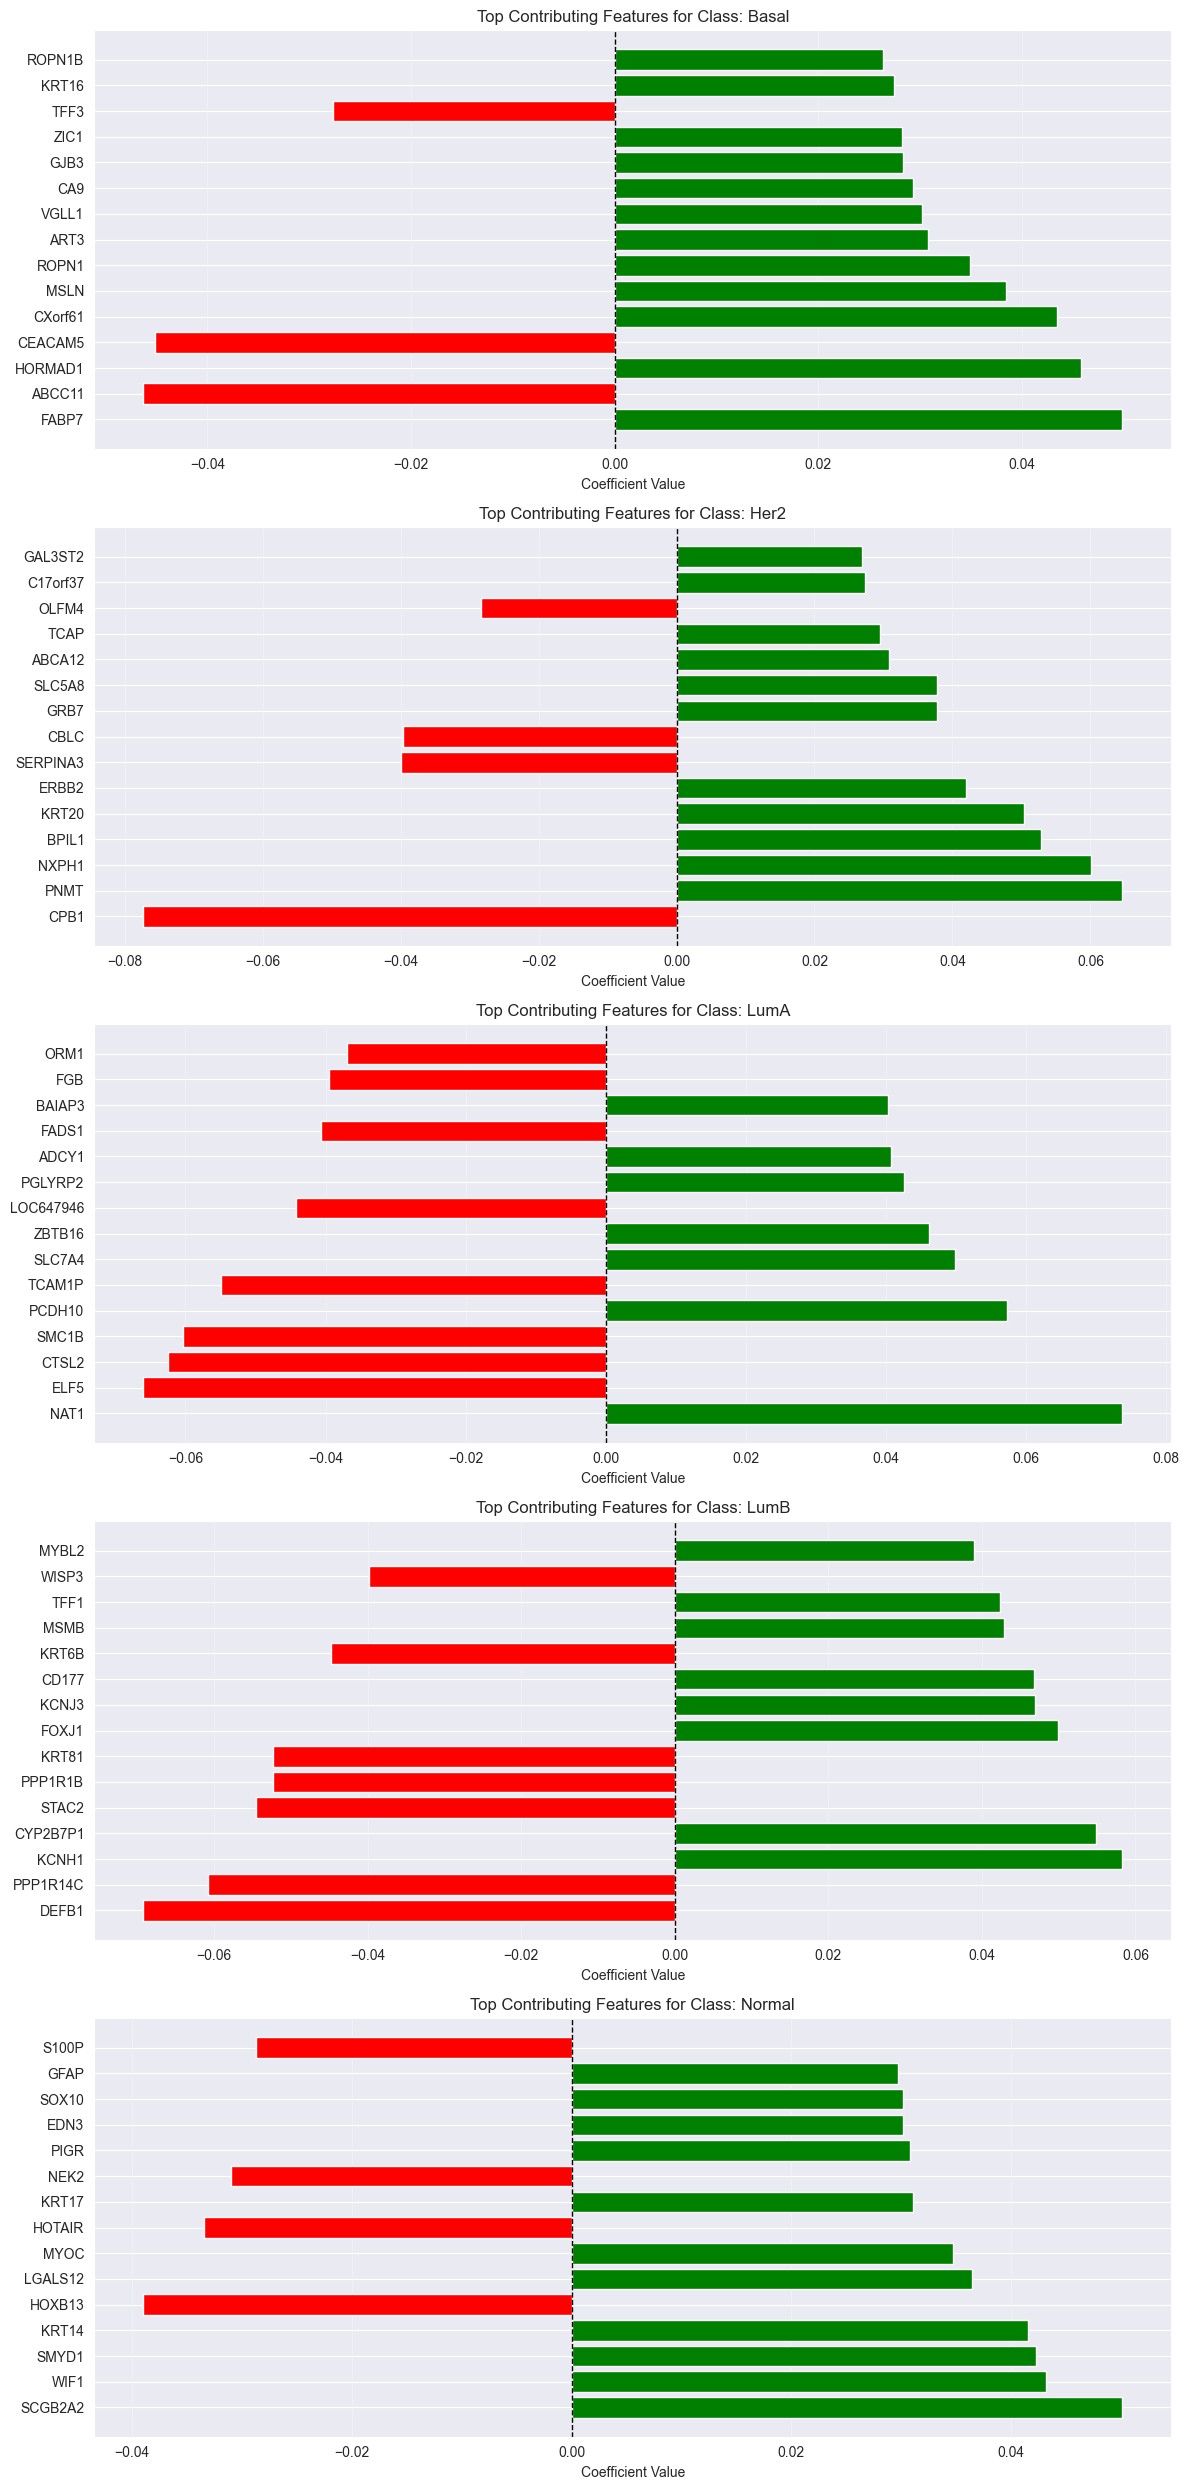

In [25]:
# Visualize top features for each class
n_classes = len(le.classes_)
fig, axes = plt.subplots(n_classes, 1, figsize=(12, 5*n_classes))

if n_classes == 1:
    axes = [axes]

for class_idx, class_name in enumerate(le.classes_):
    class_coef = lasso.coef_[class_idx]

    # Get top features by absolute coefficient
    class_features = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': class_coef
    })
    class_features['abs_coef'] = np.abs(class_features['coefficient'])
    class_features = class_features.sort_values('abs_coef', ascending=False).head(15)

    # Plot
    ax = axes[class_idx]
    colors = ['green' if c > 0 else 'red' for c in class_features['coefficient']]
    ax.barh(class_features['feature'], class_features['coefficient'], color=colors)
    ax.set_xlabel('Coefficient Value')
    ax.set_title(f'Top Contributing Features for Class: {class_name}')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
# Initialize SHAP explainer for linear models
print("Creating SHAP explainer...")
explainer = shap.LinearExplainer(lasso, X_train_scaled, feature_perturbation="interventional")

# Calculate SHAP values for validation set
print("Computing SHAP values...")
shap_values = explainer.shap_values(X_val_scaled)

print(f"SHAP values shape: {np.array(shap_values).shape}")
print("SHAP values computed successfully!")

Creating SHAP explainer...
Computing SHAP values...
SHAP values shape: (143, 20530, 5)
SHAP values computed successfully!


Generating summary plot...


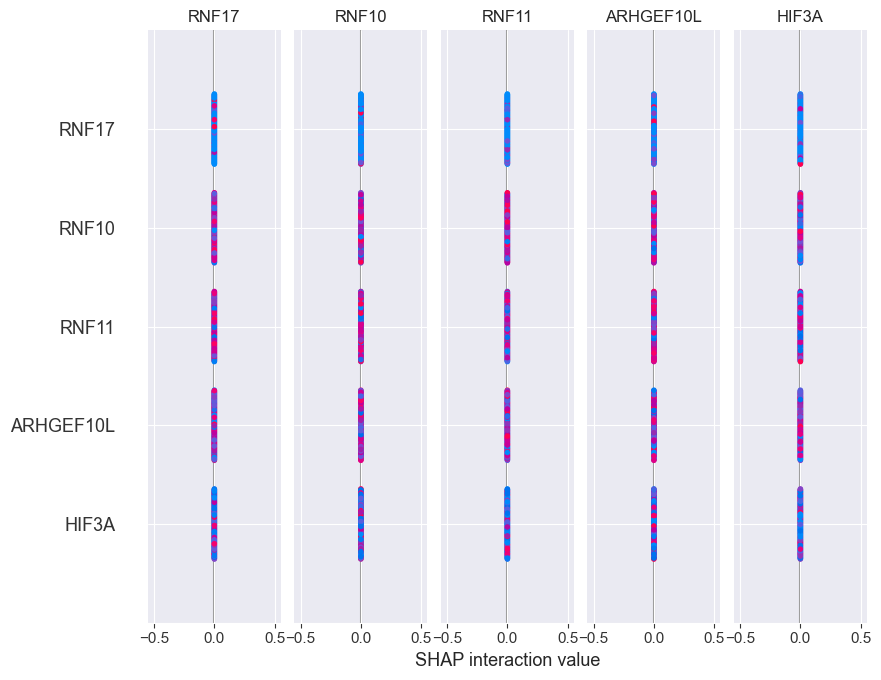

In [48]:
# 1. Summary Plot - Global Feature Importance
print("Generating summary plot...")
shap.summary_plot(shap_values, X_val_scaled, feature_names=feature_cols, class_names=le.classes_)


SHAP Summary for Class: Basal


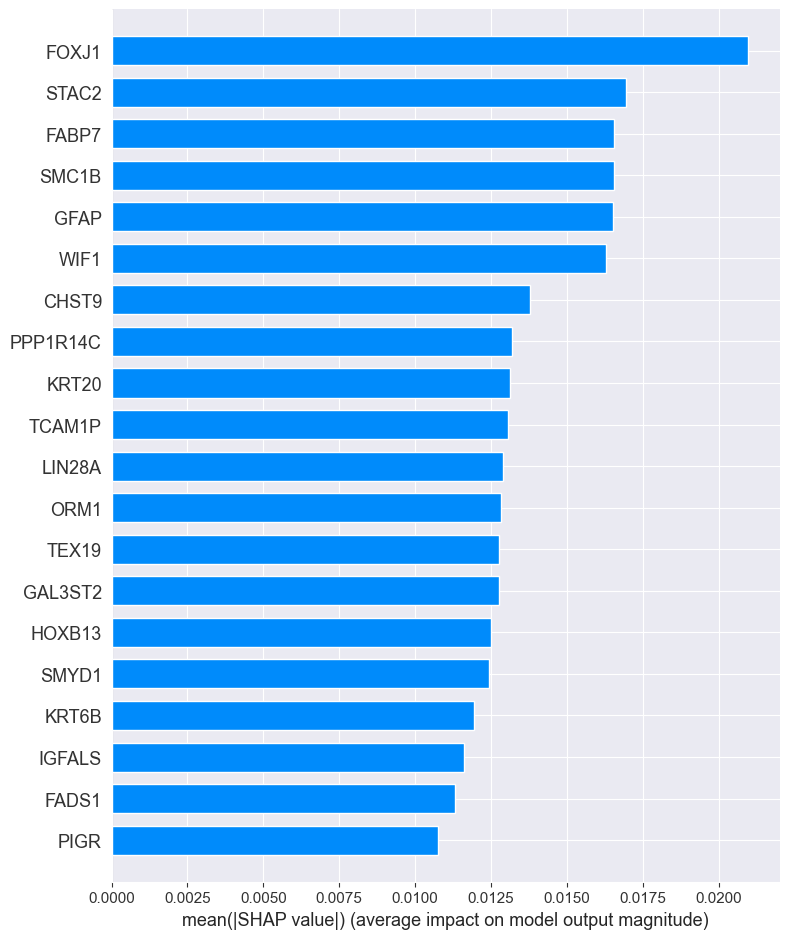


SHAP Summary for Class: Her2


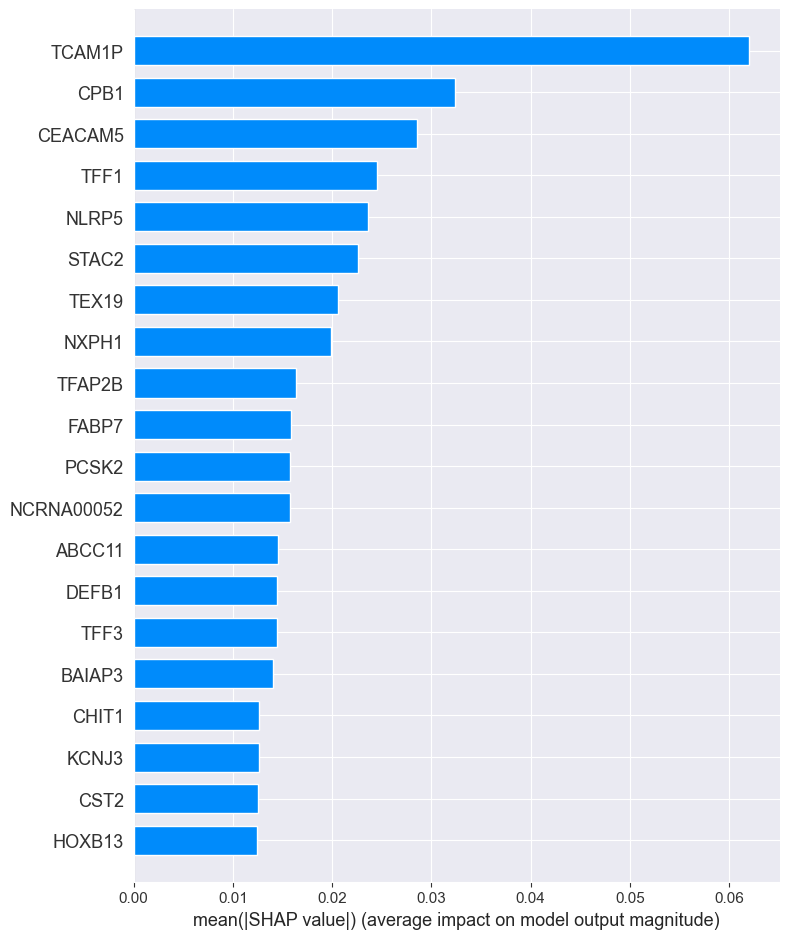


SHAP Summary for Class: LumA


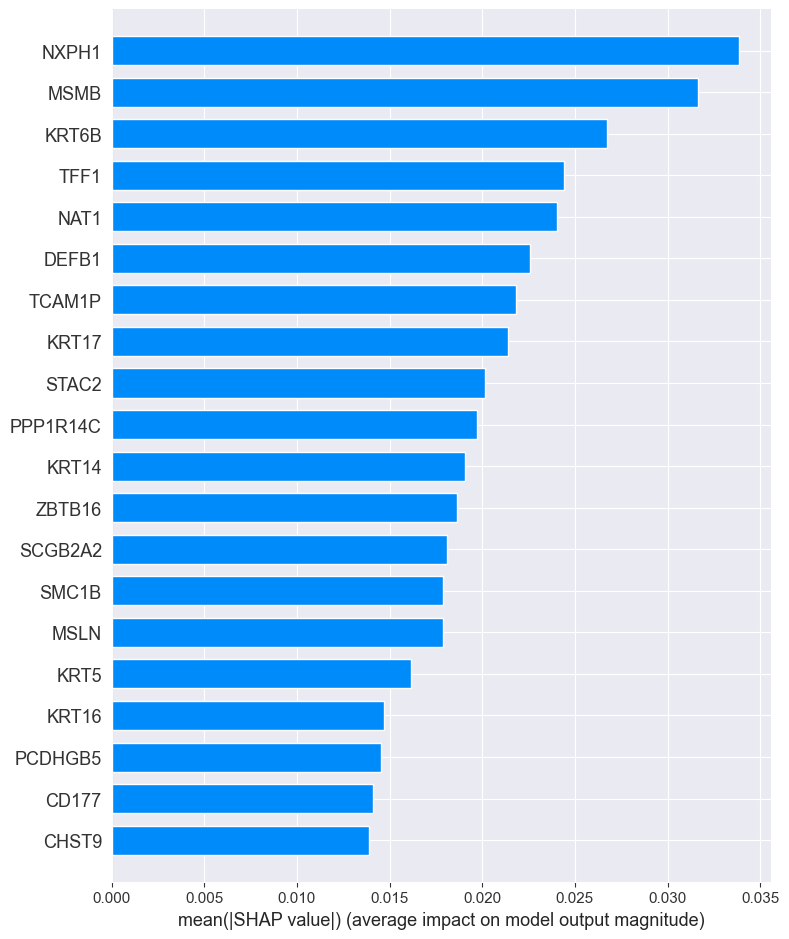


SHAP Summary for Class: LumB


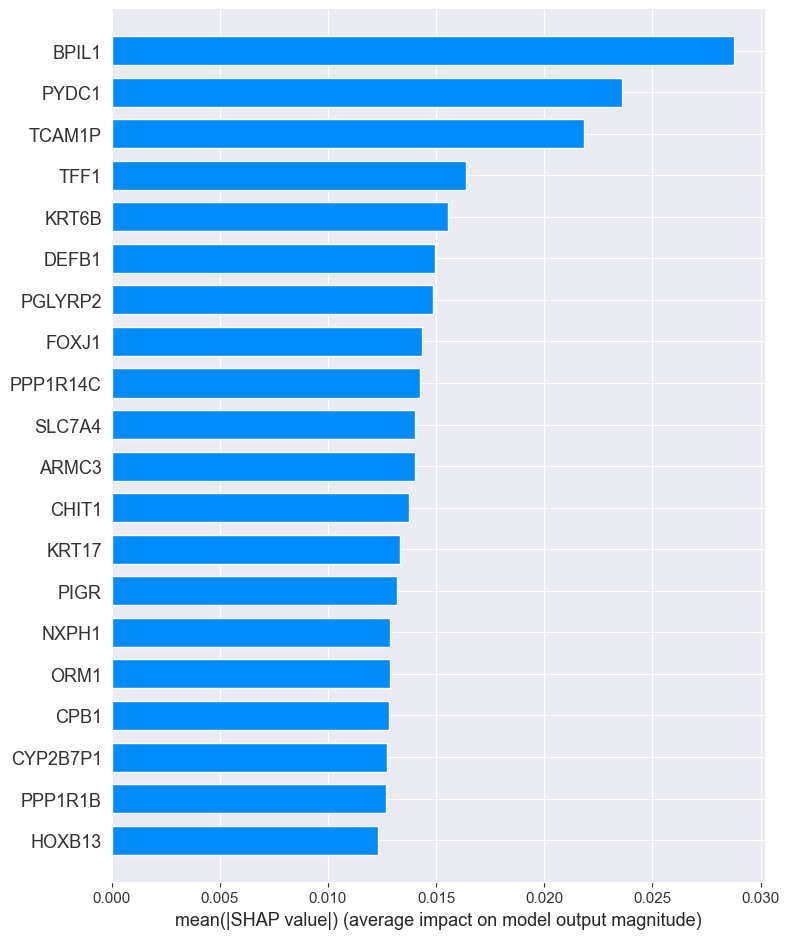


SHAP Summary for Class: Normal


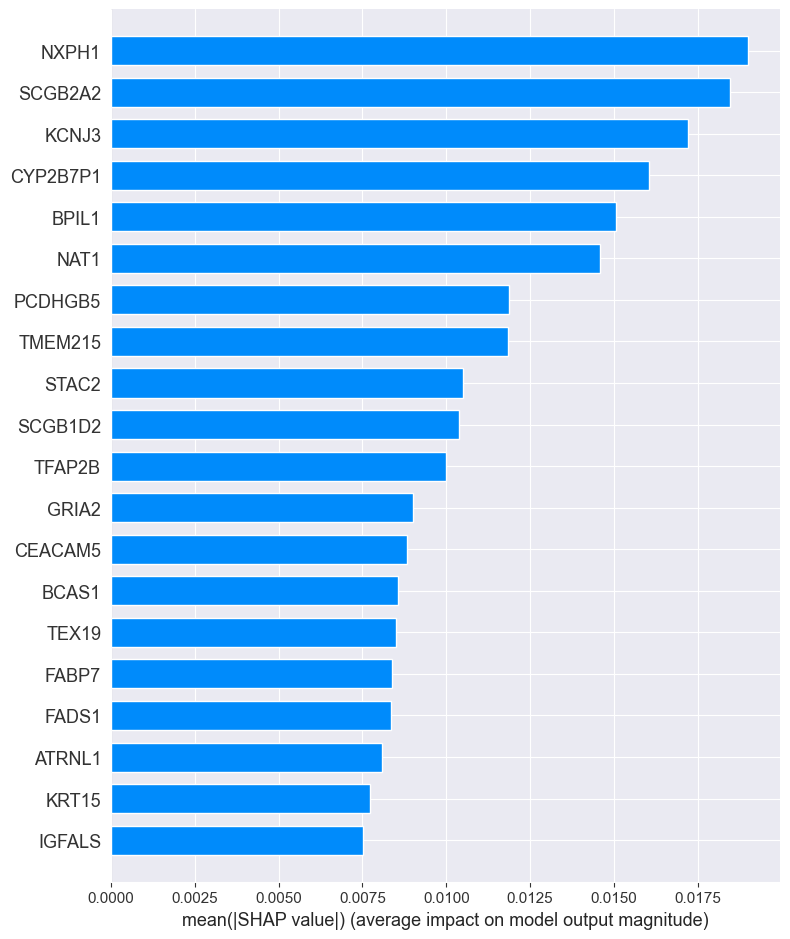

In [49]:
# 2. Summary Plot for Each Class
for class_idx, class_name in enumerate(le.classes_):
    print(f"\nSHAP Summary for Class: {class_name}")
    shap.summary_plot(shap_values[class_idx].T, X_val_scaled,
                     feature_names=feature_cols,
                     plot_type="bar",
                     max_display=20)

In [53]:
# 3. Compare SHAP vs Manual Feature Importance
# Calculate mean absolute SHAP values across all classes and samples
shap_importance_scores = []
for class_idx in range(len(le.classes_)):
    class_shap = np.abs(shap_values[class_idx].T).mean(axis=0)
    shap_importance_scores.append(class_shap)

# Average across classes
mean_shap_importance = np.mean(shap_importance_scores, axis=0)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'feature': feature_cols,
    'manual_abs_coef': feature_importance['abs_coefficient'].values,
    'shap_importance': mean_shap_importance
}).sort_values('shap_importance', ascending=False)

print("\nTop 20 Features - SHAP vs Manual Ranking:")
print(comparison_df.head(20).to_string(index=False))

# Calculate correlation between rankings
from scipy.stats import spearmanr
correlation, p_value = spearmanr(comparison_df['manual_abs_coef'],
                                  comparison_df['shap_importance'])
print(f"\nSpearman Correlation between Manual and SHAP rankings: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")


Top 20 Features - SHAP vs Manual Ranking:
 feature  manual_abs_coef  shap_importance
  TCAM1P              0.0         0.024285
   NXPH1              0.0         0.018913
    TFF1              0.0         0.016003
   STAC2              0.0         0.014726
   DEFB1              0.0         0.012828
 SCGB2A2              0.0         0.012706
   BPIL1              0.0         0.012687
    CPB1              0.0         0.012542
   KRT6B              0.0         0.012483
    NAT1              0.0         0.012235
CYP2B7P1              0.0         0.011785
PPP1R14C              0.0         0.011511
  HOXB13              0.0         0.011170
   PYDC1              0.0         0.010982
   FABP7              0.0         0.010819
   FOXJ1              0.0         0.010691
   KRT17              0.0         0.010314
 CEACAM5              0.0         0.010072
   TEX19              0.0         0.009787
    MSMB              0.0         0.009591

Spearman Correlation between Manual and SHAP rankings

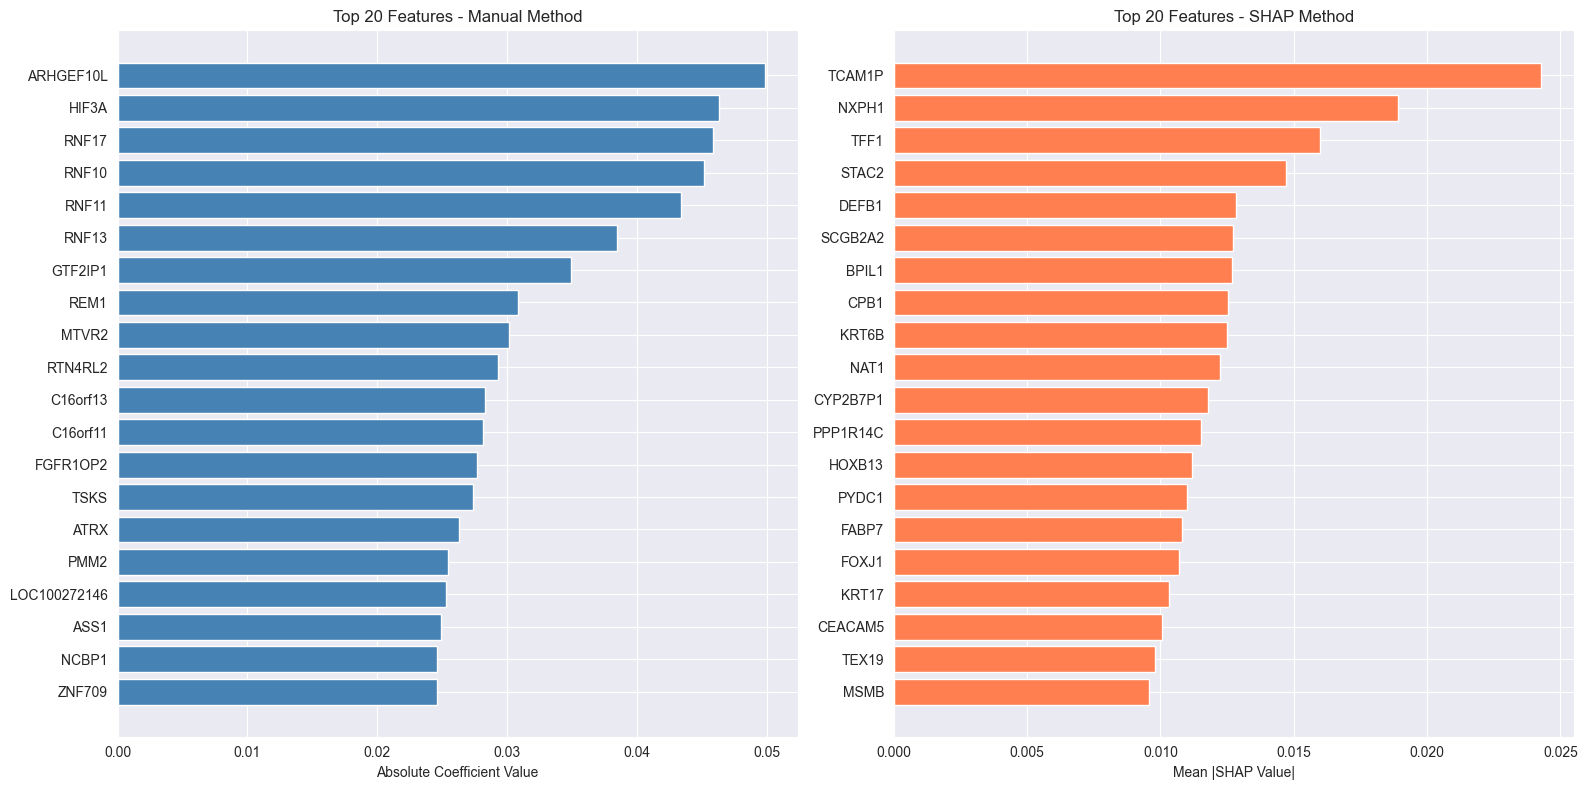

In [54]:
# 4. Side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Manual coefficients
top_manual = comparison_df.nlargest(20, 'manual_abs_coef')
axes[0].barh(top_manual['feature'], top_manual['manual_abs_coef'], color='steelblue')
axes[0].set_xlabel('Absolute Coefficient Value')
axes[0].set_title('Top 20 Features - Manual Method')
axes[0].invert_yaxis()

# SHAP importance
top_shap = comparison_df.nlargest(20, 'shap_importance')
axes[1].barh(top_shap['feature'], top_shap['shap_importance'], color='coral')
axes[1].set_xlabel('Mean |SHAP Value|')
axes[1].set_title('Top 20 Features - SHAP Method')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


############################################################
SAMPLE 0
############################################################
MANUAL EXPLANATION
Prediction: Normal
Probability: [0.0845466  0.04040477 0.37027679 0.01917081 0.48560104]

Top 10 Contributing Features:
       feature    value  coefficient  contribution
9538     FABP7   7.1168     0.049893      0.355078
16648   ABCC11   7.3286    -0.046319     -0.339455
17107  CEACAM5   6.5504    -0.045192     -0.296026
19117    PRAME  11.1812     0.025318      0.283087
16590     TFF3   9.4802    -0.027702     -0.262620
13725  SCGB2A2  12.6028    -0.017919     -0.225830
1212    C4orf7   9.2477     0.023922      0.221221
4713     FOXC1   8.2412     0.025484      0.210020
9867     BCAS1   8.1146    -0.024614     -0.199729
18492    VGLL1   6.2445     0.030169      0.188392

SHAP EXPLANATION
Predicted Class: Normal



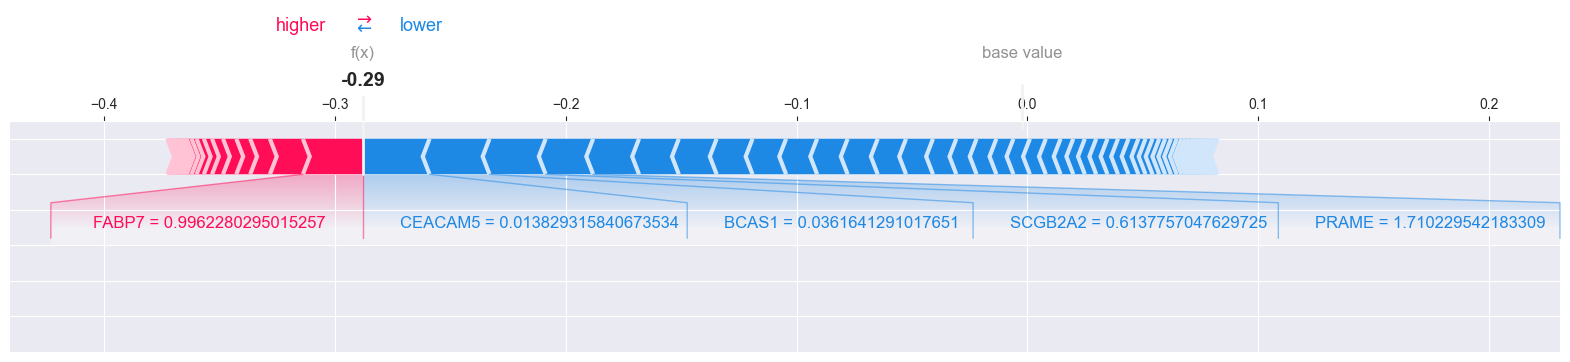

<Figure size 640x480 with 0 Axes>


Top 10 SHAP Contributors for Class 'Normal':
feature  feature_value  shap_value
CEACAM5       0.013829   -0.028904
  BCAS1       0.036164   -0.025964
  FABP7       0.996228    0.025955
SCGB2A2       0.613776   -0.024324
  PRAME       1.710230   -0.020570
    CA9      -0.425765   -0.019877
   GJB3      -0.092446   -0.017242
CXorf61      -0.258586   -0.016381
C1orf64       0.603897   -0.015543
CYP4Z2P       0.583484   -0.014541

############################################################
SAMPLE 1
############################################################
MANUAL EXPLANATION
Prediction: LumA
Probability: [0.0017525  0.01028458 0.76981357 0.21481319 0.00333616]

Top 10 Contributing Features:
       feature    value  coefficient  contribution
17107  CEACAM5  14.2433    -0.045192     -0.643684
16590     TFF3  17.5231    -0.027702     -0.485424
18247     TFF1  15.2155    -0.024632     -0.374783
9867     BCAS1  11.1878    -0.024614     -0.275371
13725  SCGB2A2  13.4909    -0.017919     -0.2

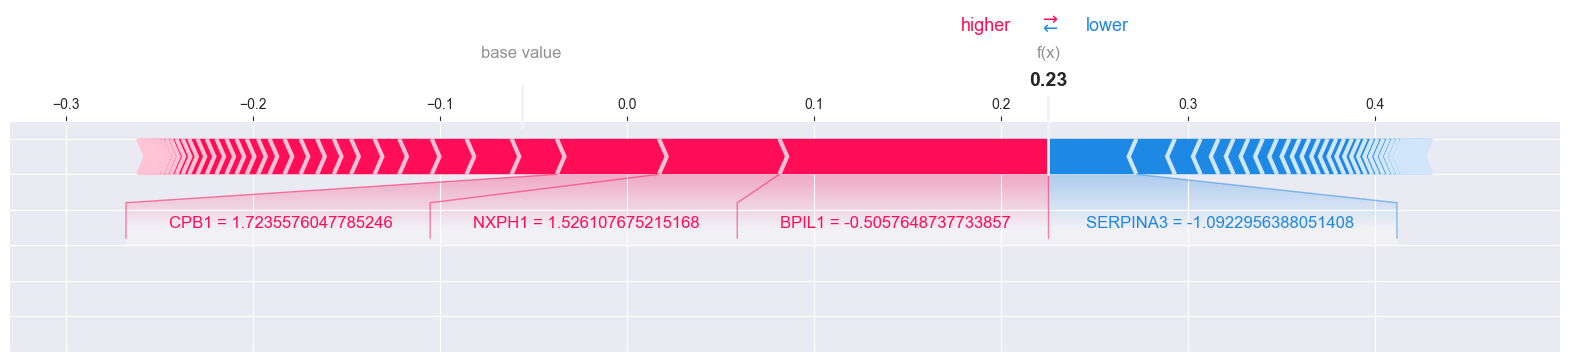

<Figure size 640x480 with 0 Axes>


Top 10 SHAP Contributors for Class 'LumB':
 feature  feature_value  shap_value
   BPIL1      -0.505765    0.143780
   NXPH1       1.526108    0.064386
    CPB1       1.723558    0.054614
SERPINA3      -1.092296   -0.047026
  LRRC31      -1.050414    0.024179
   NPY1R       0.039790    0.024080
   ABCC2       1.209324   -0.020560
 CEACAM5       2.019727    0.018591
 GAL3ST2      -0.557291    0.017373
     MIA      -0.639947   -0.013805

############################################################
SAMPLE 2
############################################################
MANUAL EXPLANATION
Prediction: LumB
Probability: [2.35605712e-04 5.35127596e-03 2.41013661e-02 9.70238754e-01
 7.29984586e-05]

Top 10 Contributing Features:
       feature    value  coefficient  contribution
16648   ABCC11   9.9686    -0.046319     -0.461738
10784     MSLN  11.2018     0.038449      0.430697
16590     TFF3  15.2705    -0.027702     -0.423022
18247     TFF1  15.1749    -0.024632     -0.373783
13725  SCGB2A2 

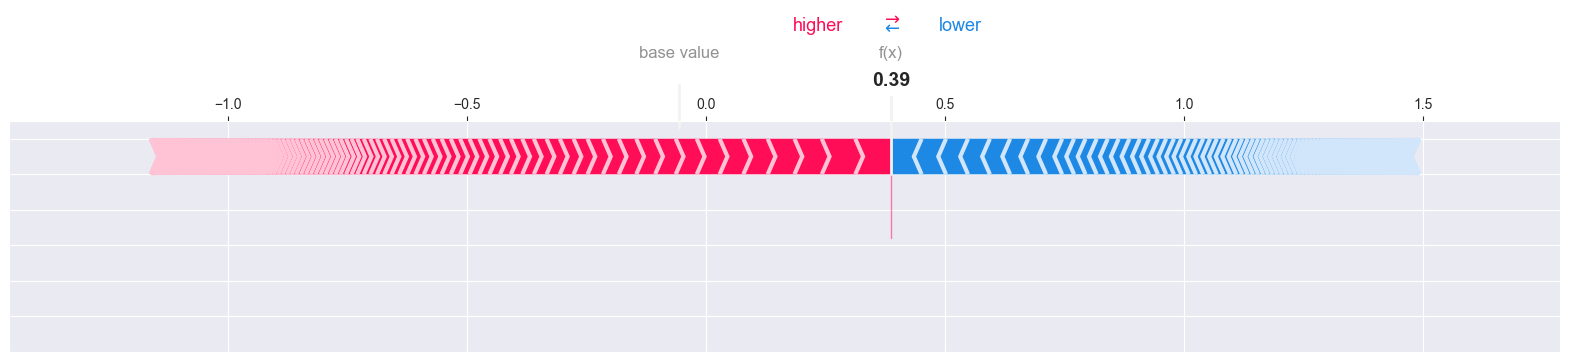

<Figure size 640x480 with 0 Axes>


Top 10 SHAP Contributors for Class 'LumB':
feature  feature_value  shap_value
PGLYRP2       0.422649    0.074374
 SLC7A4      -1.318943    0.070142
   ORM1      -0.099419   -0.064354
  PYDC1       1.526919    0.057146
 TCAM1P      -0.980875    0.056097
   ELF5       0.795793   -0.051066
    CFB       1.371160    0.050857
 BAIAP3       1.499244    0.049635
  CHIT1       1.090405    0.047889
    FGB      -0.448578   -0.045995


In [59]:
# 5. Force Plot - Explain Individual Predictions - FIXED
def explain_prediction_with_shap(sample_idx):
    """Enhanced prediction explanation using SHAP"""

    # Your original manual explanation
    print("="*60)
    print("MANUAL EXPLANATION")
    print("="*60)
    explain_prediction(sample_idx)

    # SHAP explanation for each class
    print("\n" + "="*60)
    print("SHAP EXPLANATION")
    print("="*60)

    prediction = lasso.predict(X_val_scaled[sample_idx:sample_idx+1])[0]
    predicted_class = le.inverse_transform([prediction])[0]

    print(f"Predicted Class: {predicted_class}\n")

    # Force plot for predicted class
    predicted_class_idx = prediction

    # TRANSPOSE to get correct shape: (samples, features) -> access sample_idx
    class_shap_transposed = shap_values[predicted_class_idx].T

    shap.force_plot(
        explainer.expected_value[predicted_class_idx],
        class_shap_transposed[sample_idx],  # Now accessing (sample, features)
        X_val_scaled[sample_idx],
        feature_names=feature_cols,
        matplotlib=True
    )
    plt.tight_layout()
    plt.show()

    # Top SHAP contributors for this prediction
    sample_shap = class_shap_transposed[sample_idx]  # Use transposed version
    shap_contrib = pd.DataFrame({
        'feature': feature_cols,
        'feature_value': X_val_scaled[sample_idx],
        'shap_value': sample_shap
    }).sort_values('shap_value', key=abs, ascending=False)

    print(f"\nTop 10 SHAP Contributors for Class '{predicted_class}':")
    print(shap_contrib.head(10).to_string(index=False))

# Explain first 3 validation samples
for i in range(min(3, len(X_val))):
    print(f"\n{'#'*60}")
    print(f"SAMPLE {i}")
    print('#'*60)
    explain_prediction_with_shap(i)